In [86]:
from transformers import XLNetModel, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

RANDOM_SEED = 20
NUMBER_LABELS = 5 
MODEL = 'xlnet-base-cased'
NUMBER_FEATURES = 9

tokenizer = XLNetTokenizer.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)
torch.cuda.empty_cache()

In [87]:
torch.cuda.memory_allocated()

8519680

In [88]:
NAME_TO_LOAD = "Q6"
Q_NO = 6

var_in = "Q"+str(Q_NO)+"_Q"
var_out = "Q"+str(Q_NO)+"_S"

In [89]:
IDS = [23650156,
 25357949,
 37356482,
 25262727,
 26675034,
 24109495,
 33893341,
 37638230,
 26746639,
 37329747,
 37062659,
 25318779,
 26911825,
 26685859,
 26637987,
 26119700,
 23809504,
 26834849,
 23285165,
 24109842,
 23230756,
 25416535,
 23079523,
 24966849,
 23219243,
 24594889,
 26858523,
 37973392,
 24018784,
 26541333,
 36221628,
 37720896,
 36831511,
 37962504,
 32792967,
 23344741,
 25718002,
 34136734,
 36119953,
 37544265,
 22923089,
 25111945,
 37253469,
 37713152,
 24767951,
 26390617,
 26892502,
 22752119,
 32916425,
 35194263]


# Load data

In [90]:
df =  pd.read_csv("../../data/data_old_v2/processed_data_Q"+str(Q_NO)+".csv")

# transform label
df[var_out] = df[var_out]-1

scaler = StandardScaler()
features_df = df.loc[:,'length_in_words':]
features_df = features_df.drop(['plagiarized_score', 'plagiarized_index'], axis = 1)
features = pd.DataFrame(scaler.fit_transform(features_df))
df = pd.concat([df.loc[:,['ID',var_in,var_out]].reset_index(), features], axis=1)
df=df.drop(columns='index')

df = df[df['ID'].isin(IDS)]

In [91]:
df

,ID,Q6_Q,Q6_S,0,1,2,3,4,5,6,7,8
26,22752119,Please Share With Us Two (2) Instances When Yo...,3.0,0.617387,0.503590,-0.512575,0.678315,-0.352263,-0.132147,0.804074,0.058129,-0.675493
82,22923089,Please Share With Us Two (2) Instances When Yo...,3.0,0.478127,0.476559,-0.390798,0.518383,0.011643,0.809968,0.149056,-16.209826,-0.328131
146,23079523,Please Share With Us Two (2) Instances When Yo...,0.0,-1.072720,-1.145333,0.477478,-2.308833,0.185269,-0.977477,0.987644,0.145186,0.810817
279,23219243,Please Share With Us Two (2) Instances When Yo...,3.0,0.649037,0.692811,-0.220987,0.185854,-0.230048,0.155799,0.234292,0.138026,-0.477076
389,23230756,Please Share With Us Two (2) Instances When Yo...,2.0,-0.648611,-0.672281,-0.221667,-0.169846,-0.307343,-0.429081,0.679703,0.121060,0.114088
450,23285165,Please Share With Us Two (2) Instances When Yo...,4.0,0.617387,0.503590,-0.216753,0.957648,-0.436104,-0.550672,0.686913,0.124696,-0.204155
478,23344741,Please Share With Us Two (2) Instances When Yo...,3.0,0.668027,0.706327,0.990461,-0.496393,-0.377648,-0.393173,0.647719,0.139519,-0.261787
646,23809504,Please Share With Us Two (2) Instances When Yo...,1.0,-1.041070,-1.118301,-0.907634,0.232015,-0.359834,-0.344967,0.896518,0.130339,1.788983
669,24018784,Please Share With Us Two (2) Instances When Yo...,2.0,0.370517,0.571169,0.647175,0.121259,-0.401558,0.109524,1.124687,-0.990811,-0.599229
692,24109842,Please Share With Us Two (2) Instances When Yo...,0.0,-1.262620,-1.496743,4.183406,-0.469109,-1.026071,-0.977477,-2.017131,0.163210,3.796797


# Create a pytorch dataset class and dataloader

In [92]:
class LFG_dataset(Dataset):

  def __init__(self,tokenizer, max_len, answers, scores, features):
    self.tokenizer = tokenizer
    self.max_len = max_len

    # answer and scores
    self.answers = answers
    self.scores = scores

    self.features = features
  
  def __len__(self):
    return len(self.answers)
  
  def __getitem__(self, idx):
    answer = self.answers[idx]
    score = self.scores[idx]
    features = self.features[idx]
   
    encoding = tokenizer(
      answer,
      max_length = self.max_len,
      padding ='max_length',
      truncation = True,
      return_tensors='pt',
    )

    
    return {
      'answer_text': answer,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'score' : torch.tensor(score, dtype=torch.long),
      'features': torch.tensor(features,dtype=torch.float32)
    }

In [93]:
def create_data_loader(df, tokenizer, max_len, batch_size=1):
  ds = LFG_dataset(
    tokenizer=tokenizer,
    max_len=max_len,
    answers=df[var_in].to_numpy(),
    scores=df[var_out].to_numpy().astype(int),
    features= df.iloc[:,2:].to_numpy().astype(float)
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [94]:
data_loader = create_data_loader(df.drop(columns = 'ID'), tokenizer, 550)

# Model and loss function

In [95]:
class LFG_grading(nn.Module):

    def __init__(self, n_classes, n_features):
        super(LFG_grading, self).__init__()
        self.xlnet = XLNetModel.from_pretrained(MODEL)

        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear((self.xlnet.config.hidden_size + n_features), 350)
        self.fc2 = nn.Linear(350,350)
        self.fc3 = nn.Linear(350,n_classes)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
  
    def forward(self, input_ids, attention_mask, features):
        output = self.xlnet(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        # Get the first element of output which is the hidden state
        # Get the embeddings of CLS token
        cls_embeddings = output[0][:,-1,:]
        
        # Add features along with cls embeddings
        output = torch.concat([cls_embeddings,features], dim=1)

        # Layer 1
        output = self.drop(output)
        output = self.fc1(output)
        output = self.relu(output)
        
        # Layer 2
        output = self.drop(output)
        output = self.fc2(output)
        output = self.relu(output)
        
        #Layer 3
        output = self.drop(output)
        output = self.fc3(output)
        return self.softmax(output)

    def requires_grad_embeddings(self, val):
        for param in self.xlnet.parameters():
            param.requires_grad = val   
  

In [96]:
# Save the model to a file
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

# Load the model from a file
def load_model(model_class, n_classes,n_features, file_path):
    model = model_class(n_classes, n_features)
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {file_path}")
    return model

# Inference loop

In [97]:
model = load_model(LFG_grading,NUMBER_LABELS,NUMBER_FEATURES,f"result_combined_overall_v3/{NAME_TO_LOAD}.pth")
model.requires_grad_embeddings(False)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from result_combined_overall_v3/Q6.pth


In [98]:
def test_epoch(model, data_loader, device):
    predictions = torch.tensor([], dtype=torch.long).to(device)
    targets = torch.tensor([], dtype=torch.long).to(device)

    model = model.eval()
    with torch.no_grad():
        for i,d in enumerate(tqdm(data_loader)):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            score = d["score"].to(device)
            features = d["features"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features = features
            )

            predictions = torch.cat((predictions,outputs.argmax(dim=1)), dim=0)
            targets = torch.cat((targets,score), dim=0)
    return targets, predictions

100%|██████████| 45/45 [00:03<00:00, 13.79it/s]


F1 score 0.36346737812272617
Accuracy 0.4666666666666667


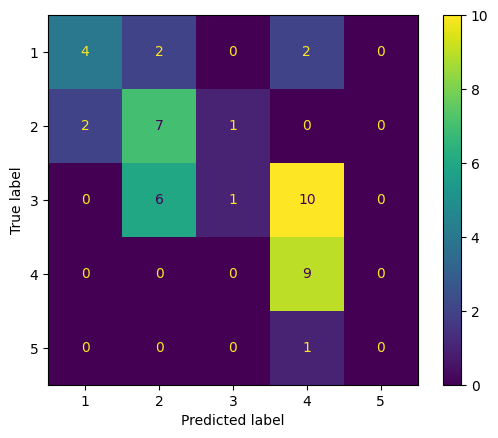

In [99]:
true, predict = test_epoch(model.to(device), data_loader, device)
true = true.to('cpu')
predict = predict.to('cpu')
cm=confusion_matrix(true, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
# disp.figure_.savefig(NAME_TO_LOAD)
disp.plot()
print(f"F1 score {f1_score(true, predict, average='macro')}")
print(f"Accuracy {accuracy_score(true, predict)}")


Export result

In [100]:
df['predict'] = predict
df.to_csv(f"result_{NAME_TO_LOAD}")

F1 score 0.7963800904977376
Accuracy 0.8


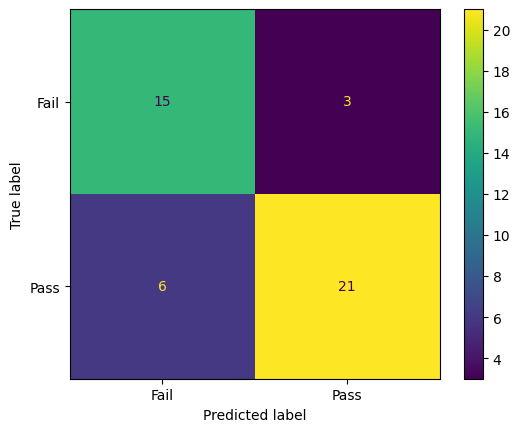

In [101]:
true_pf = true >= 2
predict_pf = predict>=2
cm=confusion_matrix(true_pf, predict_pf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail','Pass'])
disp.plot()
disp.figure_.savefig(f'{NAME_TO_LOAD}_pass_fail')
print(f"F1 score {f1_score(true_pf, predict_pf, average='macro')}")
print(f"Accuracy {accuracy_score(true_pf, predict_pf)}")


In [102]:
del model